In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. AlexNet

We'll use the **pretrained version** of AlexNet. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

![AlexNet](images\alexnet.png)

Activations:
* ReLU activation function **(hidden layer)**
* Softmax activation function **(output layer)**

Regularization:
* Dropout layers
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize AlexNet model and reshape the last layer with the correct number of classes.
    
    Since AlexNet has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        AlexNet model, as pytorch object
    """
    model = models.alexnet(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| AlexNet                       | 0.44            | 84%                 |

Best trial **configuration** for AlexNet: lr: 0.0001, l2: 0.0001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=10,
                    num_samples=1, 
                    cpus_per_trial=2,
                    gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2021-08-27 20:53:07,781	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-27 20:53:09,840	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Memory usage on this node: 2.6/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/3.8 GiB heap, 0.0/1.9 GiB objects
Result logdir: /home/lampros/ray_results/tune_helper_2021-08-27_20-53-09
Number of trials: 2/2 (2 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_c96d6_00000 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_c96d6_00001 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


(pid=2853) Parameters to learn:
(pid=2853) 	 classifier.6.weight
(pid=2853) 	 classifier.6.bias
(pid=2852) Parameters to learn:
(pid=2852) 	 classifier.6.weight
(pid=2852) 	 classifier.6.bias


(pid=2853) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=2853)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=2852) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=2852)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_c96d6_00001:
  accuracy: 0.7771
  date: 2021-08-27_21-05-49
  done: false
  experiment_id: deb4fb260cd442d4a9545019401bf3a7
  hostname: cbir
  iterations_since_restore: 1
  loss: 0.6699651586022347
  node_ip: 10.0.0.4
  pid: 2852
  time_since_restore: 758.6143343448639
  time_this_iter_s: 758.6143343448639
  time_total_s: 758.6143343448639
  timestamp: 1630098349
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c96d6_00001
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.8 GiB heap, 0.0/1.9 GiB objects
Result logdir: /home/lampros/ray_results/tune_helper_2021-08-27_20-53-09
Number of trials: 2/2 (2 RUNNING)
+-------------------------+----------+---------------+--------+--------+----------+------------+----------------------+
| Trial name              | status   | loc      

2021-08-28 15:49:18,738	INFO tune.py:550 -- Total run time: 68168.90 seconds (68168.76 seconds for the tuning loop).


Result for tune_helper_c96d6_00001:
  accuracy: 0.8457
  date: 2021-08-28_15-49-18
  done: true
  experiment_id: deb4fb260cd442d4a9545019401bf3a7
  hostname: cbir
  iterations_since_restore: 100
  loss: 0.44544261826831066
  node_ip: 10.0.0.4
  pid: 2852
  time_since_restore: 68167.70486164093
  time_this_iter_s: 664.2174215316772
  time_total_s: 68167.70486164093
  timestamp: 1630165758
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: c96d6_00001
  
== Status ==
Memory usage on this node: 2.9/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: -0.4473702770889185 | Iter 40.000: -0.44930153591617655 | Iter 20.000: -0.46138310698187274 | Iter 10.000: -0.48892456421237085
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/3.8 GiB heap, 0.0/1.9 GiB objects (0.0/2.0 CPU_group_0_180e6b25b7f3427c7390dac7a048694a, 0.0/2.0 CPU_group_180e6b25b7f3427c7390dac7a048694a)
Result logdir: /home/lampros/ray_results/tune_helper_2021-08-27_20-53-09
Number of trials: 2/2 (2 TERMI

# 4. Fit and Predict

In [7]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [8]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.0001, l2: 0.0001

Results: 
* Best **epoch**: 53
* Best **train**: **accuracy**: 89.6%, **avg loss**: 0.316507
* Best **test**: **accuracy**: 84.7%, **avg loss**: 0.445809

In [9]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [11]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\lampr/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100.0%


Model architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feature

Create an optimizer that **only** updates the desired parameters

In [12]:
learning_rate = 0.0001
weight_decay = 0.0001

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 classifier.6.weight
	 classifier.6.bias


## 5.2 Fit and predict

In [13]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.508406 [    0/50000]
loss: 1.011680 [ 6400/50000]
loss: 0.857752 [12800/50000]
loss: 0.650951 [19200/50000]
loss: 0.813582 [25600/50000]
loss: 0.601914 [32000/50000]
loss: 0.551707 [38400/50000]
loss: 0.735459 [44800/50000]

Train:
-------
accuracy: 79.2%, avg loss: 0.632800

Test:
-------
accuracy: 78.5%, avg loss: 0.646412

-------------------------------
Epoch 2
-------------------------------
loss: 0.669806 [    0/50000]
loss: 0.720969 [ 6400/50000]
loss: 0.882089 [12800/50000]
loss: 0.584777 [19200/50000]
loss: 0.640147 [25600/50000]
loss: 0.742130 [32000/50000]
loss: 0.958918 [38400/50000]
loss: 0.426686 [44800/50000]

Train:
-------
accuracy: 81.6%, avg loss: 0.548680

Test:
-------
accuracy: 80.0%, avg loss: 0.573456

-------------------------------
Epoch 3
-------------------------------
loss: 0.636814 [    0/50000]
loss: 0.564964 [ 6400/50000]
loss: 0.596143 [12800/50000]
loss: 0.628721 [19200/50000]
loss: 0.534963 [25600/50000]
loss: 0.568181 [32000/50000]
loss: 0.69

loss: 0.457044 [ 6400/50000]
loss: 0.594979 [12800/50000]
loss: 0.417531 [19200/50000]
loss: 0.492832 [25600/50000]
loss: 0.463661 [32000/50000]
loss: 0.536706 [38400/50000]
loss: 0.527865 [44800/50000]

Train:
-------
accuracy: 87.7%, avg loss: 0.366377

Test:
-------
accuracy: 84.2%, avg loss: 0.460904

-------------------------------
Epoch 22
-------------------------------
loss: 0.462674 [    0/50000]
loss: 0.418749 [ 6400/50000]
loss: 0.530876 [12800/50000]
loss: 0.462832 [19200/50000]
loss: 0.381240 [25600/50000]
loss: 0.496737 [32000/50000]
loss: 0.491305 [38400/50000]
loss: 0.686766 [44800/50000]

Train:
-------
accuracy: 88.0%, avg loss: 0.360976

Test:
-------
accuracy: 84.2%, avg loss: 0.457533

-------------------------------
Epoch 23
-------------------------------
loss: 0.403995 [    0/50000]
loss: 0.318101 [ 6400/50000]
loss: 0.703695 [12800/50000]
loss: 0.510842 [19200/50000]
loss: 0.198172 [25600/50000]
loss: 0.511217 [32000/50000]
loss: 0.370308 [38400/50000]
loss: 0.

loss: 0.590470 [12800/50000]
loss: 0.441433 [19200/50000]
loss: 0.277101 [25600/50000]
loss: 0.539146 [32000/50000]
loss: 0.414153 [38400/50000]
loss: 0.518081 [44800/50000]

Train:
-------
accuracy: 89.1%, avg loss: 0.328127

Test:
-------
accuracy: 84.4%, avg loss: 0.450607

-------------------------------
Epoch 42
-------------------------------
loss: 0.370552 [    0/50000]
loss: 0.368565 [ 6400/50000]
loss: 0.524178 [12800/50000]
loss: 0.296897 [19200/50000]
loss: 0.295481 [25600/50000]
loss: 0.344630 [32000/50000]
loss: 0.658433 [38400/50000]
loss: 0.494609 [44800/50000]

Train:
-------
accuracy: 88.6%, avg loss: 0.335194

Test:
-------
accuracy: 83.8%, avg loss: 0.460087

-------------------------------
Epoch 43
-------------------------------
loss: 0.491375 [    0/50000]
loss: 0.424751 [ 6400/50000]
loss: 0.306710 [12800/50000]
loss: 0.627150 [19200/50000]
loss: 0.483264 [25600/50000]
loss: 0.510146 [32000/50000]
loss: 0.500948 [38400/50000]
loss: 0.322798 [44800/50000]

Train:


loss: 0.403009 [19200/50000]
loss: 0.548755 [25600/50000]
loss: 0.411921 [32000/50000]
loss: 0.340021 [38400/50000]
loss: 0.429367 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315962

Test:
-------
accuracy: 84.4%, avg loss: 0.446393

-------------------------------
Epoch 62
-------------------------------
loss: 0.340382 [    0/50000]
loss: 0.469967 [ 6400/50000]
loss: 0.402262 [12800/50000]
loss: 0.356731 [19200/50000]
loss: 0.304943 [25600/50000]
loss: 0.503149 [32000/50000]
loss: 0.381033 [38400/50000]
loss: 0.539432 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315210

Test:
-------
accuracy: 84.5%, avg loss: 0.445606

-------------------------------
Epoch 63
-------------------------------
loss: 0.385326 [    0/50000]
loss: 0.505759 [ 6400/50000]
loss: 0.384270 [12800/50000]
loss: 0.444191 [19200/50000]
loss: 0.410613 [25600/50000]
loss: 0.419948 [32000/50000]
loss: 0.395635 [38400/50000]
loss: 0.567890 [44800/50000]

Train:
-------
accuracy: 89.6%, avg 

loss: 0.366176 [25600/50000]
loss: 0.269486 [32000/50000]
loss: 0.434244 [38400/50000]
loss: 0.385151 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315535

Test:
-------
accuracy: 84.5%, avg loss: 0.446151

-------------------------------
Epoch 82
-------------------------------
loss: 0.401461 [    0/50000]
loss: 0.484927 [ 6400/50000]
loss: 0.476460 [12800/50000]
loss: 0.390644 [19200/50000]
loss: 0.417517 [25600/50000]
loss: 0.486676 [32000/50000]
loss: 0.630175 [38400/50000]
loss: 0.590703 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315588

Test:
-------
accuracy: 84.5%, avg loss: 0.446134

-------------------------------
Epoch 83
-------------------------------
loss: 0.339831 [    0/50000]
loss: 0.380518 [ 6400/50000]
loss: 0.349563 [12800/50000]
loss: 0.546376 [19200/50000]
loss: 0.413477 [25600/50000]
loss: 0.268695 [32000/50000]
loss: 0.509286 [38400/50000]
loss: 0.445886 [44800/50000]

Train:
-------
accuracy: 89.6%, avg loss: 0.315587

Test:
-------

## 5.3 Visualize training and testing

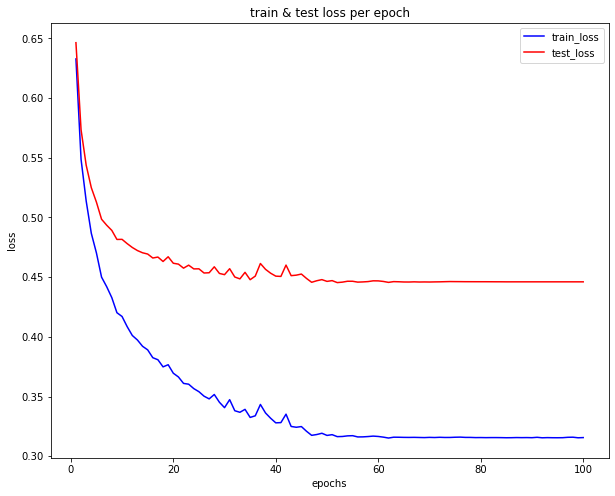

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

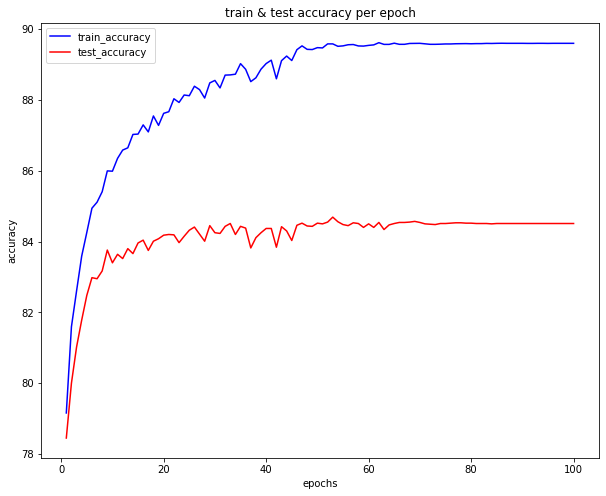

In [15]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [16]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 53
Train: accuracy: 89.6%, avg loss: 0.316507
Test: accuracy: 84.7%, avg loss: 0.445809


## 5.4 Model metrics

In [17]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.91      0.92      0.92      5000
  automobile       0.95      0.94      0.95      5000
        bird       0.92      0.81      0.86      5000
         cat       0.83      0.81      0.82      5000
        deer       0.84      0.88      0.86      5000
         dog       0.87      0.85      0.86      5000
        frog       0.89      0.93      0.91      5000
       horse       0.89      0.91      0.90      5000
        ship       0.94      0.95      0.94      5000
       truck       0.93      0.95      0.94      5000

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.90     50000
weighted avg       0.90      0.90      0.90     50000

Test:
              precision    recall  f1-score   support

    airplane       0.86      0.84      0.85      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.88      0.77      0.82      1000
         ca

<AxesSubplot:>

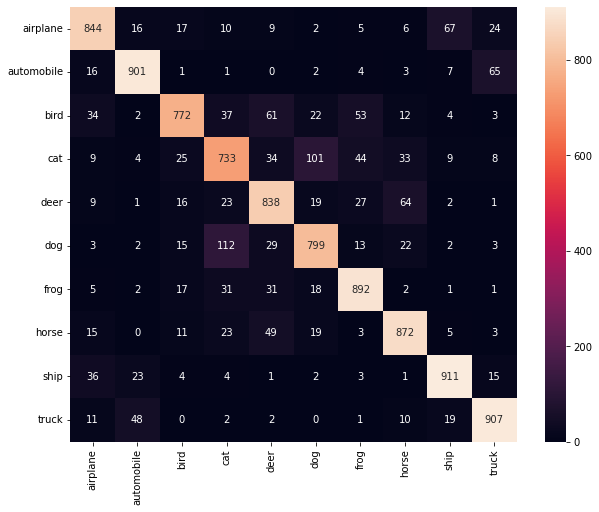

In [18]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [19]:
torch.save(best_model_state_dict, '../saved-model/alexnet-weights.pth')